# Self-Driving Car: Traffic Sign Classifier

## Deep Learning with TensorFlow

### *Daniel Wolf*



---

## Dataset Exploration

The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

import pandas as pd
signnames = pd.read_csv('data/signnames.csv')
signnames = list(signnames['ClassId'].map(str) + ': ' + signnames['SignName'])

# Extract data
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_test_orig = X_test
y_test_orig = y_test

In [2]:
# Number of classes in the dataset
num_classes = len(set(y_train))

# Traffic sign images are 32 pixels in each dimension
img_size = X_train[0].shape[0] #32

# Number of colour channels for the images: 3 channels for RGB.
num_channels = X_train[0].shape[2] #3

print("Image Shape: {}".format(X_train[0].shape))
print("Number of classes: {}".format(num_classes))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)
Number of classes: 43

Training Set:   39209 samples
Test Set:       12630 samples


[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


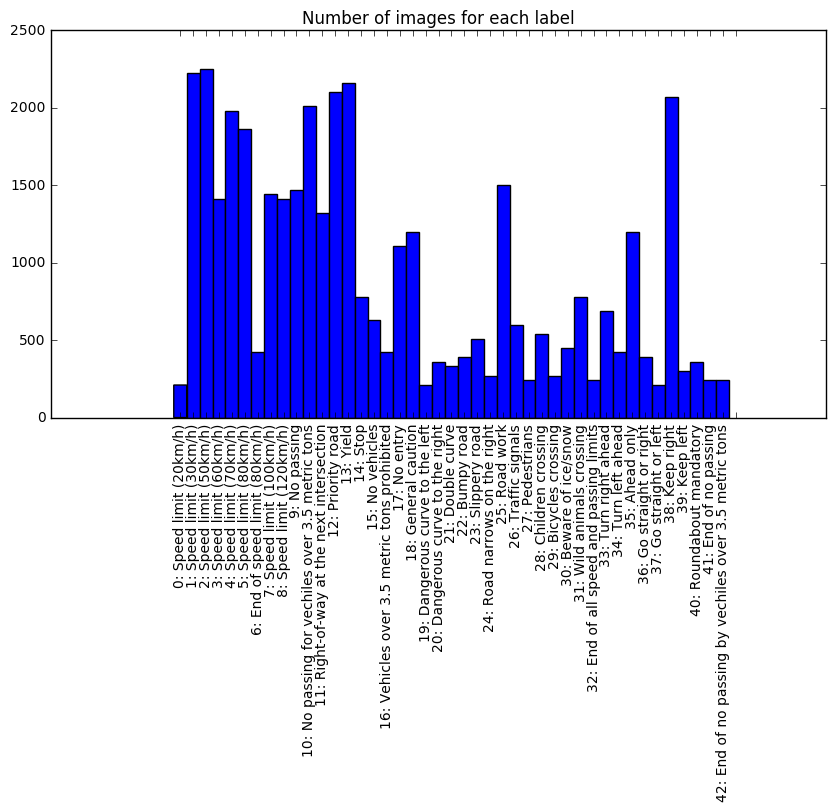

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram of the training labels to see how many are from each sign class
print(np.bincount(y_train))

plt.figure(figsize=(10,5))
plt.hist(y_train, bins=np.arange(44)-0.5)  # plt.hist passes it's arguments to np.histogram
plt.title("Number of images for each label")
plt.xticks(range(0,44), signnames, rotation=90)
plt.show()


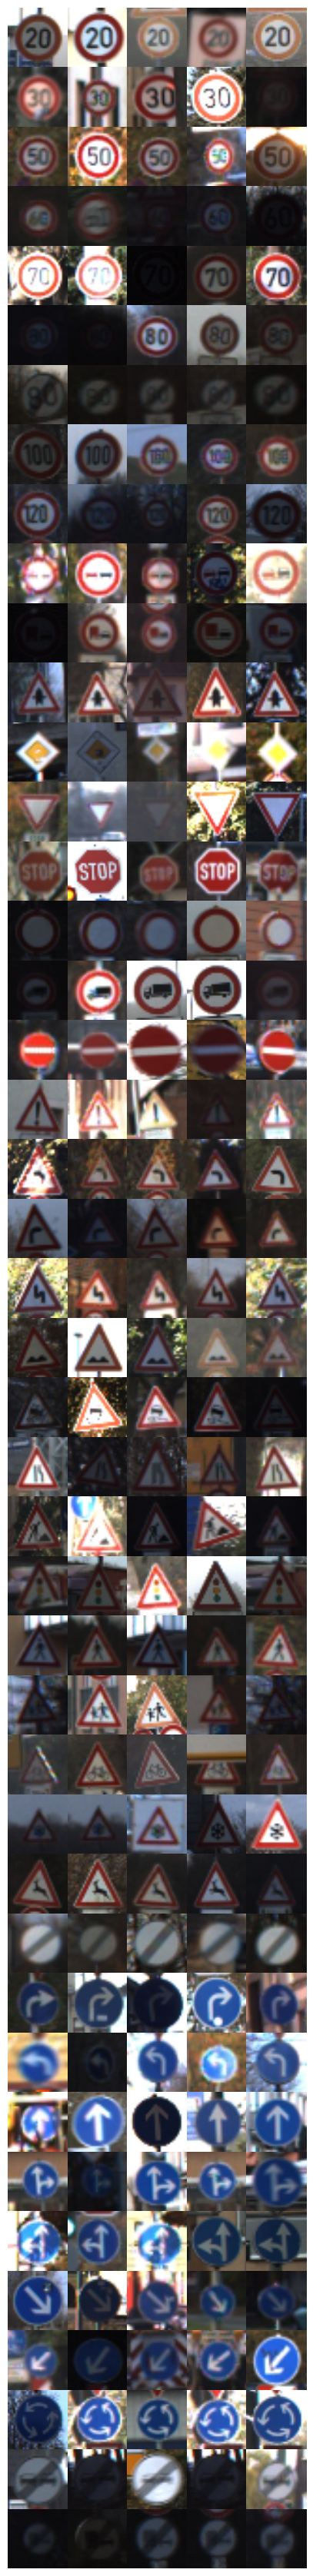

In [4]:
import matplotlib.gridspec as gridspec
import random

# Let's check out what the signs look like with a random sampling from each class

# 5 random images per class label
sample_size = 5
count = 0

fig = plt.figure(figsize=(sample_size, num_classes))
grid = gridspec.GridSpec(num_classes, sample_size, wspace=0.0, hspace=0.0)

for i in range(num_classes):
    ind = y_train == i
    # Find all images from class i
    subset_x = X_train[ind,]
    for x in range(sample_size):
        # Randomly pick an image from each class
        img = random.choice(subset_x) 
        ax = plt.Subplot(fig, grid[count])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img, cmap='gray')
        fig.add_subplot(ax)
        count +=1

    # hide the borders
    if i == (num_classes-1):
        all_axes = fig.get_axes()
        for ax in all_axes:
            for sp in ax.spines.values():
                sp.set_visible(False)

#plt.yticks(np.arange(44)*32+16, signnames)
#plt.xticks([])
plt.show()



----

## Data Preprocessing



In [5]:
import cv2

# Define a function to augment the training data through transformations
def transform_image(img,ang_range,shear_range,trans_range):
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img


In [6]:
# Number of transformed images for each original image
num_gen = 5

# Set up a new array to hold the transformed images and labels
X_train_gen = np.zeros((len(X_train) * num_gen, img_size, img_size, num_channels), dtype=np.uint8)
y_train_gen = np.zeros((len(y_train) * num_gen,), dtype=np.uint8)

# Index for the newly created arrays
count = 0
for j in range(0,len(X_train)):
    
    image = X_train[j]
    
    # Generate transformations of each original image
    for y in range(0,5):
        img = transform_image(image,5,5,1)
        X_train_gen[count] = img
        y_train_gen[count] = y_train[j]
        count += 1
    

[ 1050 11100 11250  7050  9900  9300  2100  7200  7050  7350 10050  6600
 10500 10800  3900  3150  2100  5550  6000  1050  1800  1650  1950  2550
  1350  7500  3000  1200  2700  1350  2250  3900  1200  3445  2100  6000
  1950  1050 10350  1500  1800  1200  1200]


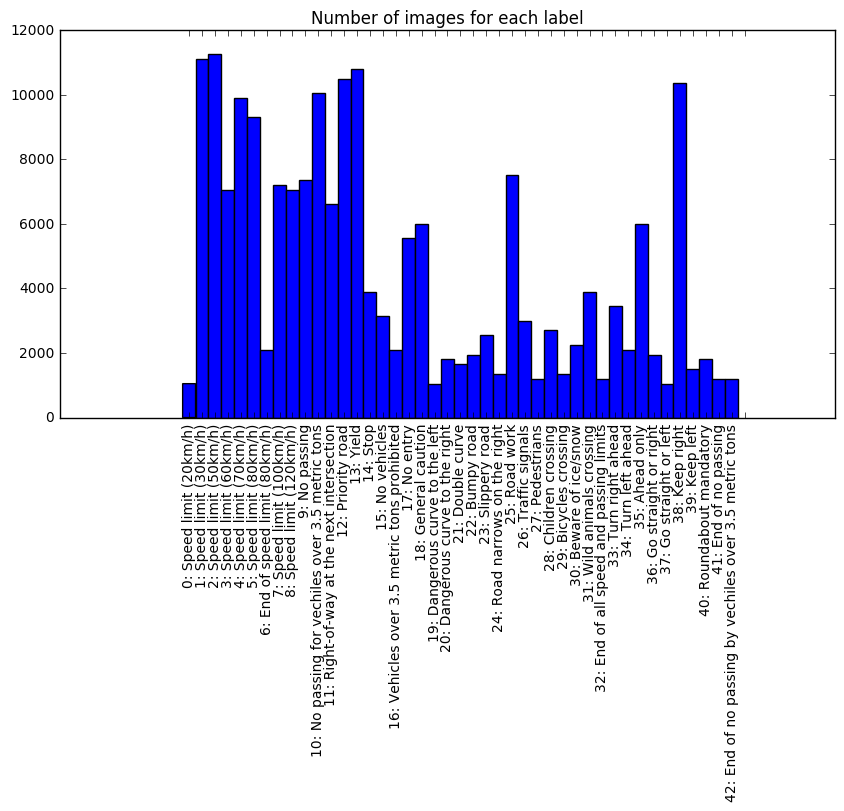

In [7]:
# Create a histogram of the training labels to see how many are from each sign class
print(np.bincount(y_train_gen))

plt.figure(figsize=(10,5))
plt.hist(y_train_gen, bins=np.arange(44)-0.5)  # plt.hist passes it's arguments to np.histogram
plt.title("Number of images for each label")
plt.xticks(range(0,44), signnames, rotation=90)
plt.show()


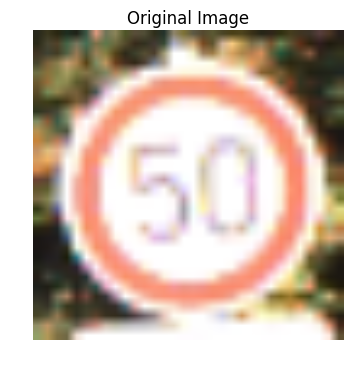

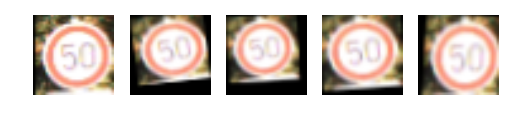

In [8]:
# Demonstrate example transformation
image = X_train[4000]
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.show()

gs1 = gridspec.GridSpec(1, 5)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(6,6))
for i in range(5):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image,5,5,5)

    plt.subplot(1,5, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [9]:
# Concatenate newly generated images with original training data
X_train = np.concatenate((X_train, X_train_gen), axis=0)
y_train = np.concatenate((y_train, y_train_gen), axis=0)

# Shuffle
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

# Split the training data into a training and validation set
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42)

print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))


Training Set:   188203 samples
Validation Set: 47051 samples
Test Set:       12630 samples


In [10]:
# One Hot Encode the labels
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
y_train = lb.transform(y_train)

lb.fit(y_valid)
y_valid = lb.transform(y_valid)

lb.fit(y_test)
y_test = lb.transform(y_test)


----

## Design and Test Neural Network



In [11]:
# Hyperparameters
learning_rate = 0.001
epochs = 50
batch_size = 256

#n_input = img_size * img_size * num_channels  # (img shape: 32*32*3 = 3072)

# tf Graph input
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, img_size, img_size, num_channels])
y = tf.placeholder(tf.int32, [None, num_classes])



In [12]:
# Function for model definition
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    keep_prob = 0.8
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.dropout(conv1, keep_prob)
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.dropout(conv2, keep_prob)
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2 = tf.nn.dropout(fc2, keep_prob)
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


In [13]:
# Training Pipeline

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)


In [14]:
# Testing pipeline

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



In [15]:
# Set up TensorFlow session and train the network

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1), "Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if validation_accuracy > 0.95:
            break
            
    print("Optimization Finished!")
    
    print("Validation Accuracy:", accuracy_operation.eval(feed_dict = 
                                           {x: X_valid, y: y_valid},
                                           session=sess))
    
    saver.save(sess, './lenet/lenet')
    print("Model saved")



Training...

EPOCH 1 ... Validation Accuracy = 0.085
EPOCH 2 ... Validation Accuracy = 0.522
EPOCH 3 ... Validation Accuracy = 0.637
EPOCH 4 ... Validation Accuracy = 0.686
EPOCH 5 ... Validation Accuracy = 0.744
EPOCH 6 ... Validation Accuracy = 0.793
EPOCH 7 ... Validation Accuracy = 0.819
EPOCH 8 ... Validation Accuracy = 0.832
EPOCH 9 ... Validation Accuracy = 0.850
EPOCH 10 ... Validation Accuracy = 0.845
EPOCH 11 ... Validation Accuracy = 0.868
EPOCH 12 ... Validation Accuracy = 0.881
EPOCH 13 ... Validation Accuracy = 0.890
EPOCH 14 ... Validation Accuracy = 0.882
EPOCH 15 ... Validation Accuracy = 0.898
EPOCH 16 ... Validation Accuracy = 0.899
EPOCH 17 ... Validation Accuracy = 0.912
EPOCH 18 ... Validation Accuracy = 0.914
EPOCH 19 ... Validation Accuracy = 0.914
EPOCH 20 ... Validation Accuracy = 0.900
EPOCH 21 ... Validation Accuracy = 0.913
EPOCH 22 ... Validation Accuracy = 0.920
EPOCH 23 ... Validation Accuracy = 0.927
EPOCH 24 ... Validation Accuracy = 0.925
EPOCH 25 ...

In [16]:
# Evaluat the accuracy on the test data
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))



Test Accuracy = 0.912


---

## Example Results


In [17]:
# Visualize the results on test images AND 2 images downloaded from online
# The online images will test performance on signs that are not in the German dataset

# Select a few test images randomly
img1 = X_test_orig[1000]
img2 = X_test_orig[2000]
img3 = X_test_orig[4000]
img4 = X_test_orig[5000]

import matplotlib.image as mpimg
import PIL
from PIL import Image

# Stop sign
img5_orig=Image.open('data/stopsigns.jpg')
img5 = img5_orig.resize((32, 32), PIL.Image.ANTIALIAS)
img5 = np.asarray(img5, dtype = np.uint8)

# Wild animals sign
img6_orig=Image.open('data/wildanimal.jpg')
img6 = img6_orig.resize((32, 32), PIL.Image.ANTIALIAS)
img6 = np.asarray(img6, dtype = np.uint8)

# Merge 5 photos into a numpy array for processing
my_x = np.concatenate(([img1], [img2], [img3], [img4], [img5], [img6]), axis=0)

# Define the correct labels:
my_y = [y_test_orig[1000], y_test_orig[2000], y_test_orig[4000], y_test_orig[5000], 14, 31]

# Calculate softmax probabilities of the most likely predicted labels
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k_preds = sess.run(tf.nn.top_k(tf.nn.softmax(logits) , k=5), feed_dict={x: my_x})



In [18]:
# Grabbing an example image of any given label
def get_example(label):
    
    ind = y_test_orig == label
    # Find all images from class i
    subset_x = X_test_orig[ind,]
    return subset_x[0]
    

In [21]:
# Printing and visualizing results
def print_example(image, label, predicted, probability):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))
    f.tight_layout()
    ax1.set_title('Actual Photo')#, fontsize=30)
    ax1.imshow(image)
    ax2.set_title('Example of Predicted Label')#, fontsize=30)
    ax2.imshow(get_example(predicted[0]).astype(np.uint8))
    plt.show()
    print("Top 5 Predicted Labels and Probabilities")
    df = list(zip(predicted, probability))
    for i in range(0,5):
        print(signnames[int(df[i][0])] + ": " + "{0:.0000f}%".format(df[i][1]))
    print("Correct label: " + str(label) + ' -- ' + signnames[label])
    if label == predicted[0]:
        print("Correct prediction!")
    else:
        print("Incorrect prediction")



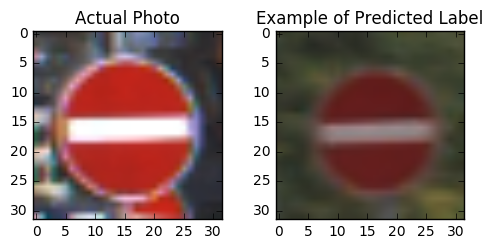

Top 5 Predicted Labels and Probabilities
17: No entry: 100%
16: Vehicles over 3.5 metric tons prohibited: 0%
0: Speed limit (20km/h): 0%
1: Speed limit (30km/h): 0%
2: Speed limit (50km/h): 0%
Correct label: 17 -- 17: No entry
Correct prediction!


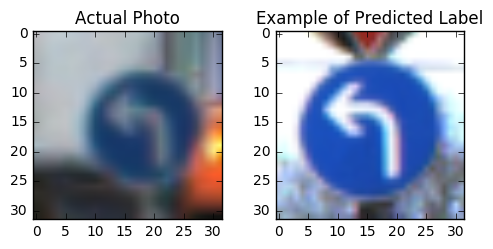

Top 5 Predicted Labels and Probabilities
34: Turn left ahead: 94%
38: Keep right: 6%
35: Ahead only: 0%
11: Right-of-way at the next intersection: 0%
13: Yield: 0%
Correct label: 34 -- 34: Turn left ahead
Correct prediction!


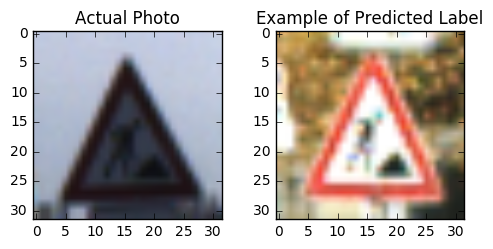

Top 5 Predicted Labels and Probabilities
25: Road work: 100%
20: Dangerous curve to the right: 0%
22: Bumpy road: 0%
30: Beware of ice/snow: 0%
29: Bicycles crossing: 0%
Correct label: 25 -- 25: Road work
Correct prediction!


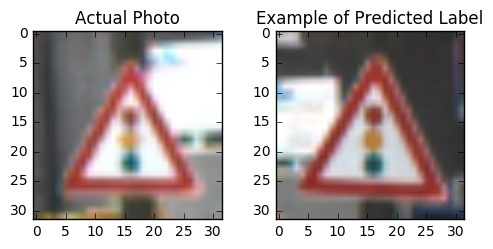

Top 5 Predicted Labels and Probabilities
26: Traffic signals: 100%
18: General caution: 0%
22: Bumpy road: 0%
27: Pedestrians: 0%
25: Road work: 0%
Correct label: 26 -- 26: Traffic signals
Correct prediction!


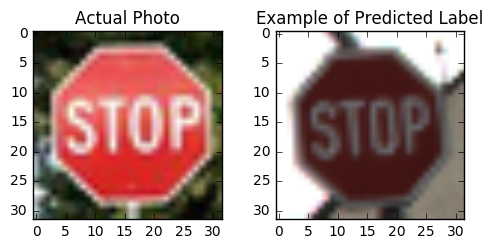

Top 5 Predicted Labels and Probabilities
14: Stop: 100%
17: No entry: 0%
9: No passing: 0%
15: No vehicles: 0%
0: Speed limit (20km/h): 0%
Correct label: 14 -- 14: Stop
Correct prediction!


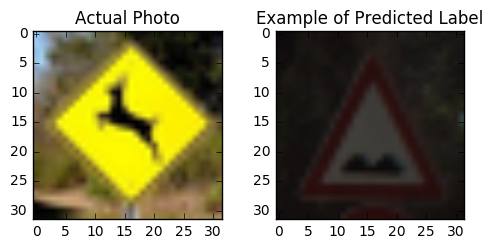

Top 5 Predicted Labels and Probabilities
22: Bumpy road: 57%
17: No entry: 11%
16: Vehicles over 3.5 metric tons prohibited: 11%
9: No passing: 7%
26: Traffic signals: 6%
Correct label: 31 -- 31: Wild animals crossing
Incorrect prediction


In [22]:
# Visualize the softmax probabilities of each prediction

top_k_preds_array = np.array(top_k_preds)
top_k_preds_array[0] = top_k_preds_array[0] * 100

for i in range(0,len(my_x)):
    print_example(my_x[i], my_y[i], top_k_preds_array[1][i], top_k_preds_array[0][i])

